## Import packages

In [1]:
import os
import shutil
import glob
import urllib.request
import tarfile

import re
import numpy as np
import pandas as pd 
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

tf.compat.v1.disable_eager_execution()

## Configs and Hyperparameters

In [2]:
WORKSPACE_PATH = '/content'
ANNOTATION_PATH = WORKSPACE_PATH+'/dataset'
DATASET_PATH = ANNOTATION_PATH+'/images'
LABEL_MAP_PBTXT_FNAME = ANNOTATION_PATH + '/object-detection.pbtxt'
CONFIG_PATH = WORKSPACE_PATH + '/configs'
TRAINING_DIR = WORKSPACE_PATH + '/training'

DATASET_TRAIN = DATASET_PATH + '/training'
DATASET_VAL = DATASET_PATH + '/validation'
DATASET_TEST = DATASET_PATH + '/test'

TFRECORD_TRAIN = ANNOTATION_PATH + '/train.record'
TFRECORD_VAL = ANNOTATION_PATH + '/val.record'
CSV_TEST = ANNOTATION_PATH + '/data_test.csv'

In [3]:
files_train = os.listdir(DATASET_TRAIN)
jpg_files_train = [file for file in files_train if file.lower().endswith(".jpg")]

files_eval = os.listdir(DATASET_VAL)
jpg_files_eval = [file for file in files_eval if file.lower().endswith(".jpg")]

In [4]:
NUM_TRAIN_DATASET = len(jpg_files_train)
NUM_EVAL_DATASET = len(jpg_files_eval)
BATCH_SIZE = 1
EPOCH = 100

NUM_STEPS_TRAIN = NUM_TRAIN_DATASET * BATCH_SIZE * EPOCH
NUM_STEPS_EVAL = NUM_EVAL_DATASET * BATCH_SIZE

In [5]:
MODELS_CONFIG = {
    'faster_rcnn_resnet50': {
        'model_name': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
        'pipeline_file': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config',
    },
    'faster_rcnn_resnet101': {
        'model_name': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8',
        'pipeline_file': 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config',
    },
    'faster_rcnn_resnet152': {
        'model_name': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8',
        'pipeline_file': 'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config',
    }
}

In [6]:
selected_model = 'faster_rcnn_resnet50'

In [7]:
MODEL = MODELS_CONFIG[selected_model]['model_name']
PIPELINE_FILE = MODELS_CONFIG[selected_model]['pipeline_file']

MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
DEST_DIR = '/content/pretrained_model/' + selected_model 
FINE_TUNE_CHECKPOINT = DEST_DIR + "/checkpoint/ckpt-0"
MODEL_DIR = TRAINING_DIR + '/' + selected_model
OUTPUT_DIRECTORY = '/content/fine_tuned_model/' + selected_model

OUTPUT_PATH = '/content/outputs/'
SAVED_DETECTION = OUTPUT_PATH + selected_model
SAVED_MODEL = OUTPUT_DIRECTORY + '/saved_model'
OUTPUT_CSV = f'{OUTPUT_PATH}output_{selected_model}.csv'

In [8]:
MODEL_FILE

'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz'

## Function Download Base Model

In [9]:
def download_base_model(dest_dir, download_base, model_file, model):
    if os.path.exists(dest_dir):
        print(f"Folder {dest_dir} sudah ada. Tidak perlu mengunduh ulang base model.")
    else:
        # Unduh dan ekstrak model jika folder tidak ada
        if not (os.path.exists(MODEL_FILE)):
            urllib.request.urlretrieve(download_base + model_file, model_file)

        tar = tarfile.open(model_file)
        tar.extractall()
        tar.close()

        # os.remove(model_file)
        if (os.path.exists(dest_dir)):
            shutil.rmtree(dest_dir)
        os.rename(model, dest_dir)

## Function Create Confusion Matrix and Evaluate

In [10]:
def evaluate_model(csv_path):
    # Membaca file CSV
    df = pd.read_csv(csv_path)

    # Mendapatkan nilai unik dari kolom 'true_label' dan tambahkan 'None'
    labels = sorted(df['true_label'].unique())
    labels.append('None')

    # Membuat confusion matrix
    conf_matrix = confusion_matrix(df['true_label'], df['predict_label'], labels=labels)

    # Menghitung evaluasi
    accuracy = accuracy_score(df['true_label'], df['predict_label'])
    precision = precision_score(df['true_label'], df['predict_label'], average='weighted', labels=df['true_label'].unique())
    recall = recall_score(df['true_label'], df['predict_label'], average='weighted', labels=df['true_label'].unique())

    # Menghitung rata-rata execute time dan total execute time
    average_exec_time = np.mean(df['execute_time'])
    average_exec_time_formatted = "{:.2f} ms".format(average_exec_time)
    total_exec_time = np.sum(df['execute_time'])
    total_exec_time_formatted = "{:.2f} s".format(total_exec_time/1000)

    # Generate classification report
    class_report = classification_report(df['true_label'], df['predict_label'], labels=labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Average Execution Time:", average_exec_time_formatted)
    print("Total Execution Time:", total_exec_time_formatted)

    # Print classification report
    print("\nClassification Report:")
    print(class_report)

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Install required packages

In [4]:
# !pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

Wall time: 1.24 s


DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453


In [11]:
!pip install scipy

In [12]:
!pip install lvis

In [13]:
# !git clone --quiet https://github.com/tensorflow/models.git
#!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
#conda install -c conda-forge protobuf pil lxml tk

In [14]:
%cd /content/models/research

D:\content\models\research


In [15]:
!copy "object_detection\packages\tf2\setup.py" .

        1 file(s) copied.


In [16]:
# !python -m pip install .

In [17]:
# !python slim/setup.py install

In [18]:
!cd

D:\content\models\research


In [11]:
import os

# Tentukan path yang ingin Anda tambahkan
path_to_add = r'D:\content\models\research'
path_to_add_slim = r'D:\content\models\research\slim'

# Periksa apakah path sudah ada di dalam PYTHONPATH
if path_to_add not in os.environ.get('PYTHONPATH', '').split(os.pathsep):
    # Tambahkan path ke PYTHONPATH
    os.environ['PYTHONPATH'] = f"{path_to_add}{os.pathsep}{os.environ.get('PYTHONPATH', '')}"

# Periksa apakah path_slim sudah ada di dalam PYTHONPATH
if path_to_add_slim not in os.environ.get('PYTHONPATH', '').split(os.pathsep):
    # Tambahkan path_slim ke PYTHONPATH
    os.environ['PYTHONPATH'] = f"{path_to_add_slim}{os.pathsep}{os.environ.get('PYTHONPATH', '')}"

# Cetak PYTHONPATH setelah penambahan
print("PYTHONPATH setelah penambahan:", os.environ.get('PYTHONPATH', ''))

PYTHONPATH setelah penambahan: D:\content\models\research\slim;D:\content\models\research;D:\Paul\Perkuliahan\PROJECT SKRIPSI\RealTimeObjectDetection\Tensorflow\models\research\slim


In [12]:
%cd /content
!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

#import os
#os.environ['PYTHONPATH'] += ':/paul/roboflow/models/research/:/paul/roboflow/models/research/slim/'
        
!python object_detection/builders/model_builder_test.py

D:\content
D:\content\models\research


# 1. Create Label Map

In [12]:
labels = [{'name': 'A', 'id': 1}, 
          {'name': 'B', 'id': 2}, 
          {'name': 'C', 'id': 3}, 
          {'name': 'D', 'id': 4}, 
          {'name': 'E', 'id': 5}, 
          {'name': 'F', 'id': 6}, 
          {'name': 'G', 'id': 7}, 
          {'name': 'H', 'id': 8}, 
          {'name': 'I', 'id': 9}, 
          {'name': 'J', 'id': 10}, 
          {'name': 'K', 'id': 11}, 
          {'name': 'L', 'id': 12}, 
          {'name': 'M', 'id': 13}, 
          {'name': 'N', 'id': 14}, 
          {'name': 'O', 'id': 15}, 
          {'name': 'P', 'id': 16}, 
          {'name': 'Q', 'id': 17}, 
          {'name': 'R', 'id': 18}, 
          {'name': 'S', 'id': 19}, 
          {'name': 'T', 'id': 20}, 
          {'name': 'U', 'id': 21}, 
          {'name': 'V', 'id': 22}, 
          {'name': 'W', 'id': 23}, 
          {'name': 'X', 'id': 24}, 
          {'name': 'Y', 'id': 25}, 
          {'name': 'Z', 'id': 26}]

In [13]:
with open(LABEL_MAP_PBTXT_FNAME, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Download Base Model Faster RCNN Inception V2

In [11]:
DEST_DIR

'/content/pretrained_model/faster_rcnn_resnet50'

In [12]:
MODEL_FILE

'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz'

In [13]:
%cd /content/pretrained_model
download_base_model(DEST_DIR, DOWNLOAD_BASE, MODEL_FILE, MODEL)

D:\content\pretrained_model
Folder /content/pretrained_model/faster_rcnn_resnet50 sudah ada. Tidak perlu mengunduh ulang base model.


In [14]:
!echo {DEST_DIR}
!dir "{DEST_DIR}"

/content/pretrained_model/faster_rcnn_resnet50
 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\pretrained_model\faster_rcnn_resnet50

11/07/2020  07:14    <DIR>          .
15/03/2024  16:57    <DIR>          ..
10/07/2020  11:08    <DIR>          checkpoint
11/07/2020  07:14             3.538 pipeline.config
10/07/2020  10:57    <DIR>          saved_model
               1 File(s)          3.538 bytes
               4 Dir(s)  30.675.222.528 bytes free


In [15]:
FINE_TUNE_CHECKPOINT

'/content/pretrained_model/faster_rcnn_resnet50/checkpoint/ckpt-0'

## Configuring a Training Pipeline

In [16]:
PIPELINE_FNAME = '/content/models/research/object_detection/configs/tf2/' + PIPELINE_FILE
assert os.path.isfile(PIPELINE_FNAME), '`{}` not exist'.format(PIPELINE_FNAME)

In [17]:
PIPELINE_FNAME = CONFIG_PATH + '/' + PIPELINE_FILE

In [24]:
!copy "D:\content\models\research\object_detection\configs\tf2\{PIPELINE_FILE}" "D:\content\configs"
PIPELINE_FNAME

        1 file(s) copied.


'/content/configs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config'

In [25]:
augmentation_config = """
  data_augmentation_options {
    random_horizontal_flip {
		probability: 0.3
	}
  }

  data_augmentation_options {
    random_adjust_brightness {
		max_delta: 0.3
	}
  }
"""

In [26]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [27]:
def modify_pipeline_config(pipeline_filename):
    with open(pipeline_filename) as f:
        s = f.read()

    # Replace fine_tune_checkpoint and fine_tune_checkpoint_type
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(FINE_TUNE_CHECKPOINT), s)
    s = re.sub('fine_tune_checkpoint_type: "classification"',
               'fine_tune_checkpoint_type: "detection"', s)

    # Replace tfrecord files for train and val
    s = re.sub(
        '(input_path: ".*?train.*?)(.tfrecord)(.*?")', 'input_path: "{}"'.format(TFRECORD_TRAIN), s)
    s = re.sub(
        '(input_path: ".*?val.*?)(.tfrecord)(.*?")', 'input_path: "{}"'.format(TFRECORD_VAL), s)

    # Replace label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(LABEL_MAP_PBTXT_FNAME), s)

    # Set training batch_size
    s = re.sub('batch_size: [0-9]+', 'batch_size: {}'.format(BATCH_SIZE), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}\n  batch_queue_capacity: 3000\n  num_batch_queue_threads: 100\n  prefetch_queue_capacity: 1500'.format(NUM_STEPS_TRAIN), s)
    s = re.sub('total_steps: [0-9]+', 'total_steps: {}'.format(NUM_STEPS_TRAIN), s)

    # Set number of classes num_classes
    num_classes = get_num_classes(LABEL_MAP_PBTXT_FNAME)
    s = re.sub('num_classes: [0-9]+', 'num_classes: {}'.format(num_classes), s)

    # Change use_matmul_crop_and_resize to false
    s = re.sub('use_matmul_crop_and_resize: true',
               'use_matmul_crop_and_resize: false', s)

    # Change use_matmul_gather_in_matcher to false
    s = re.sub('use_matmul_gather_in_matcher: true',
               'use_matmul_gather_in_matcher: false', s)

    # Replace keep_aspect_ratio_resizer with fixed_shape_resizer
    s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)

    # Replace width from 640 to 320
    s = re.sub('min_dimension: 640', 'width: 320', s)

    # Replace height from 640 to 320
    s = re.sub('max_dimension: 640', 'height: 320', s)

    # Remove the line containing pad_to_max_dimension: true
    s = re.sub('\s*pad_to_max_dimension: true\n', '\n', s)
    
    s = re.sub(r'data_augmentation_options {\s*random_horizontal_flip {\s*}\s*}',augmentation_config,s)

    with open(pipeline_filename, 'w') as f:
        f.write(s)

In [28]:
PIPELINE_FNAME

'/content/configs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config'

In [29]:
modify_pipeline_config(PIPELINE_FNAME)

In [30]:
!cat "D:\content\configs\faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config"

# Faster R-CNN with Resnet-50 (v1) with 640x640 input resolution
# Trained on COCO, initialized from Imagenet classification checkpoint
#
# Train on TPU-8
#
# Achieves 29.3 mAP on COCO17 Val

model {
  faster_rcnn {
    num_classes: 26
    image_resizer {
      fixed_shape_resizer {
        width: 320
        height: 320
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet50_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_m

In [31]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Directory '{MODEL_DIR}' created successfully.")

In [32]:
# Optionally remove content in output model directory to fresh start.
!rmdir /s /q "{MODEL_DIR}"
os.makedirs(MODEL_DIR, exist_ok=True)

### Get Tensorboard link

In [39]:
#tensorboard --logdir=.

## Train the model

In [34]:
!python "D:\content\models\research\object_detection\model_main_tf2.py" \
    --pipeline_config_path={PIPELINE_FNAME} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr \
    --num_train_steps={NUM_STEPS_TRAIN} \
    --num_eval_steps={NUM_STEPS_EVAL}

2024-04-25 14:59:36.675360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 14:59:37.263589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0425 14:59:37.400394 26104 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 46800
I0425 14:59:37.402395 26104 config_util.py:552] Maybe overwriting train_steps: 46800
INFO:

In [22]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--alsologtostderr "
    "--model_dir={} "
    "--num_train_steps={} "
    "--num_eval_steps={} "
).format(PIPELINE_FNAME, MODEL_DIR, NUM_STEPS_TRAIN, NUM_STEPS_EVAL)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config --alsologtostderr --model_dir=/content/training/faster_rcnn_resnet50 --num_train_steps=46800 --num_eval_steps=52 


In [31]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--checkpoint_dir={} "
    "--model_dir={} "
).format(PIPELINE_FNAME, MODEL_DIR, MODEL_DIR)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config --checkpoint_dir=/content/training/faster_rcnn_resnet50 --model_dir=/content/training/faster_rcnn_resnet50 


In [35]:
!dir "{MODEL_DIR}"

 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\training\faster_rcnn_resnet50

25/04/2024  16:17    <DIR>          .
25/04/2024  14:58    <DIR>          ..
25/04/2024  16:17               705 checkpoint
25/04/2024  16:07       226.929.299 ckpt-41.data-00000-of-00001
25/04/2024  16:07            35.115 ckpt-41.index
25/04/2024  16:09       226.929.299 ckpt-42.data-00000-of-00001
25/04/2024  16:09            35.115 ckpt-42.index
25/04/2024  16:11       226.929.299 ckpt-43.data-00000-of-00001
25/04/2024  16:11            35.115 ckpt-43.index
25/04/2024  16:12       226.929.299 ckpt-44.data-00000-of-00001
25/04/2024  16:12            35.115 ckpt-44.index
25/04/2024  16:14       226.929.299 ckpt-45.data-00000-of-00001
25/04/2024  16:14            35.115 ckpt-45.index
25/04/2024  16:16       226.929.299 ckpt-46.data-00000-of-00001
25/04/2024  16:16            35.115 ckpt-46.index
25/04/2024  16:17       226.929.299 ckpt-47.data-00000-of-00001
25/

## Exporting a Trained Inference Graph

In [36]:
lst = os.listdir(MODEL_DIR)
lst = [l for l in lst if 'ckpt-' in l and '.index' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(MODEL_DIR, last_model)
print(last_model_path)

/content/training/faster_rcnn_resnet50\ckpt-47.index


In [37]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet50'

In [38]:
!python "D:\content\models\research\object_detection\exporter_main_v2.py" \
    --input_type image_tensor \
    --pipeline_config_path "D:\content\configs\faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config" \
    --trained_checkpoint_dir {MODEL_DIR} \
    --output_directory {OUTPUT_DIRECTORY}

2024-04-25 16:35:11.031382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 16:35:11.841853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0425 16:35:12.051476  5664 deprecation.py:628] From C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\tensorflow\python\autograph\impl\api.py:45

In [39]:
!dir "{OUTPUT_DIRECTORY}"

 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\fine_tuned_model\faster_rcnn_resnet50

25/04/2024  16:35    <DIR>          .
25/04/2024  16:35    <DIR>          ..
25/04/2024  16:35    <DIR>          checkpoint
25/04/2024  16:35             3.552 pipeline.config
25/04/2024  16:35    <DIR>          saved_model
               1 File(s)          3.552 bytes
               4 Dir(s)  28.847.788.032 bytes free


## Run Test model

In [11]:
%cd /content

D:\content


In [12]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet50'

In [13]:
CSV_TEST

'/content/dataset/data_test.csv'

In [14]:
print("python ./detect_image_from_csv.py -m "+SAVED_MODEL+" -s "+SAVED_DETECTION+"  -l "+LABEL_MAP_PBTXT_FNAME+" -i "+DATASET_TEST+"")

python ./detect_image_from_csv.py -m /content/fine_tuned_model/faster_rcnn_resnet50/saved_model -s /content/outputs/faster_rcnn_resnet50  -l /content/dataset/object-detection.pbtxt -i /content/dataset/images/test


In [17]:
!python ./detect_image_from_csv.py -m {SAVED_MODEL} -l {LABEL_MAP_PBTXT_FNAME} -i {CSV_TEST} -o {OUTPUT_CSV} -s {SAVED_DETECTION} 

2025-05-14 10:38:55.935010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 10:38:56.826685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-05-14 10:39:18.807534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-05-14 10:39:24.650175: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9615384615384616
Precision: 0.9890109890109889
Recall: 0.9615384615384616
Average Execution Time: 408.56 ms
Total Execution Time: 63.74 s

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
           B       1.00      1.00      1.00         6
           C       1.00      1.00      1.00         6
           D       1.00      0.83      0.91         6
           E       0.86      1.00      0.92         6
           F       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         6
           H       0.86      1.00      0.92         6
           I       1.00      1.00      1.00         6
           J       1.00      1.00      1.00         6
           K       1.00      1.00      1.00         6
           L       1.00      1.00      1.00         6
           M       1.00      0.83      0.91         6
           N       1.00      1.00      1.00         6
           O   

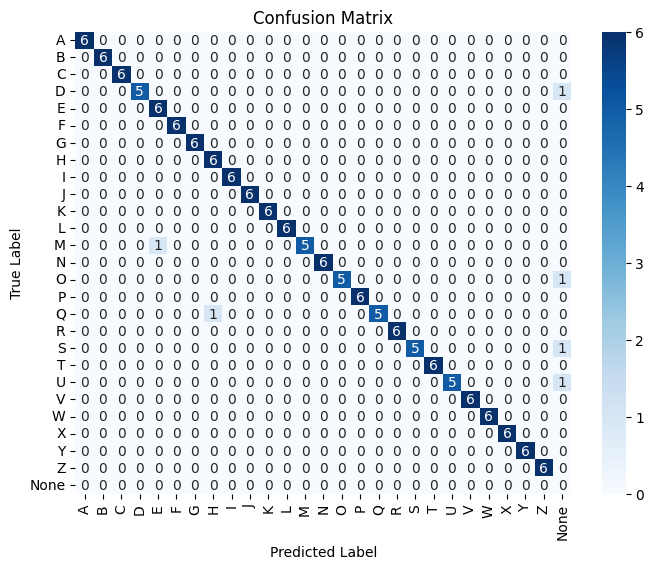

In [18]:
evaluate_model(OUTPUT_CSV)

# RESNET 101

In [19]:
selected_model = "faster_rcnn_resnet101"
MODEL = MODELS_CONFIG[selected_model]['model_name']
MODEL_FILE = MODEL + '.tar.gz'
PIPELINE_FILE = MODELS_CONFIG[selected_model]['pipeline_file']

DEST_DIR = '/content/pretrained_model/' + selected_model 
FINE_TUNE_CHECKPOINT = DEST_DIR + "/checkpoint/ckpt-0"
MODEL_DIR = TRAINING_DIR + '/' + selected_model
OUTPUT_DIRECTORY = '/content/fine_tuned_model/' + selected_model

OUTPUT_PATH = '/content/outputs/'
SAVED_DETECTION = OUTPUT_PATH + selected_model
SAVED_MODEL = OUTPUT_DIRECTORY + '/saved_model'
OUTPUT_CSV = f'{OUTPUT_PATH}output_{selected_model}.csv'

## Download Base Model Faster RCNN Inception V2 Resnet 101

In [96]:
DEST_DIR

'/content/pretrained_model/faster_rcnn_resnet101'

In [97]:
MODEL_FILE

'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz'

In [62]:
%cd /content/pretrained_model
download_base_model(DEST_DIR, DOWNLOAD_BASE, MODEL_FILE, MODEL)

D:\content\pretrained_model
Folder /content/pretrained_model/faster_rcnn_resnet101 sudah ada. Tidak perlu mengunduh ulang base model.


In [63]:
!echo {DEST_DIR}
!dir "{DEST_DIR}"

/content/pretrained_model/faster_rcnn_resnet101
 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\pretrained_model\faster_rcnn_resnet101

11/07/2020  07:14    <DIR>          .
15/03/2024  16:57    <DIR>          ..
10/07/2020  11:08    <DIR>          checkpoint
11/07/2020  07:14             3.539 pipeline.config
10/07/2020  10:56    <DIR>          saved_model
               1 File(s)          3.539 bytes
               4 Dir(s)  29.916.868.608 bytes free


In [64]:
FINE_TUNE_CHECKPOINT

'/content/pretrained_model/faster_rcnn_resnet101/checkpoint/ckpt-0'

## Configuring a Training Pipeline

In [34]:
PIPELINE_FNAME = '/content/models/research/object_detection/configs/tf2/' + PIPELINE_FILE
assert os.path.isfile(PIPELINE_FNAME), '`{}` not exist'.format(PIPELINE_FNAME)

In [65]:
PIPELINE_FNAME = CONFIG_PATH + '/' + PIPELINE_FILE

In [36]:
!copy "D:\content\models\research\object_detection\configs\tf2\{PIPELINE_FILE}" "D:\content\configs"
PIPELINE_FNAME

        1 file(s) copied.


'/content/configs/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'

In [37]:
modify_pipeline_config(PIPELINE_FNAME)

In [66]:
PIPELINE_FNAME

'/content/configs/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'

In [67]:
!cat "D:\content\configs\faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config"

# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint
#
# Train on TPU-8
#
# Achieves 31.8 mAP on COCO17 val

model {
  faster_rcnn {
    num_classes: 26
    image_resizer {
      fixed_shape_resizer {
        width: 320
        height: 320
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_s

In [68]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Directory '{MODEL_DIR}' created successfully.")

In [69]:
# Optionally remove content in output model directory to fresh start.
!rmdir /s /q "{MODEL_DIR}"
os.makedirs(MODEL_DIR, exist_ok=True)

In [71]:
!python "D:\content\models\research\object_detection\model_main_tf2.py" \
    --pipeline_config_path={PIPELINE_FNAME} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr \
    --num_train_steps={NUM_STEPS_TRAIN} \
    --num_eval_steps={NUM_STEPS_EVAL}

2024-04-25 21:36:14.940209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 21:36:15.715047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0425 21:36:15.950847 28920 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 46800
I0425 21:36:15.953848 28920 config_util.py:552] Maybe overwriting train_steps: 46800
INFO:

In [70]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--alsologtostderr "
    "--model_dir={} "
    "--num_train_steps={} "
    "--num_eval_steps={} "
).format(PIPELINE_FNAME, MODEL_DIR, NUM_STEPS_TRAIN, NUM_STEPS_EVAL)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config --alsologtostderr --model_dir=/content/training/faster_rcnn_resnet101 --num_train_steps=46800 --num_eval_steps=52 


In [72]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--checkpoint_dir={} "
    "--model_dir={} "
).format(PIPELINE_FNAME, MODEL_DIR, MODEL_DIR)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config --checkpoint_dir=/content/training/faster_rcnn_resnet101 --model_dir=/content/training/faster_rcnn_resnet101 


## Exporting a Trained Inference Graph

In [73]:
lst = os.listdir(MODEL_DIR)
lst = [l for l in lst if 'ckpt-' in l and '.index' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(MODEL_DIR, last_model)
print(last_model_path)

/content/training/faster_rcnn_resnet101\ckpt-47.index


In [74]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet101'

In [75]:
!python "D:\content\models\research\object_detection\exporter_main_v2.py" \
    --input_type image_tensor \
    --pipeline_config_path "D:\content\configs\{PIPELINE_FILE}" \
    --trained_checkpoint_dir {MODEL_DIR} \
    --output_directory {OUTPUT_DIRECTORY}

2024-04-25 23:46:52.425567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 23:46:53.519953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0425 23:46:53.730788 17892 deprecation.py:628] From C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\tensorflow\python\autograph\impl\api.py:45

In [76]:
!dir "{OUTPUT_DIRECTORY}"

 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\fine_tuned_model\faster_rcnn_resnet101

25/04/2024  23:47    <DIR>          .
25/04/2024  23:47    <DIR>          ..
25/04/2024  23:47    <DIR>          checkpoint
25/04/2024  23:47             3.554 pipeline.config
25/04/2024  23:47    <DIR>          saved_model
               1 File(s)          3.554 bytes
               4 Dir(s)  28.474.769.408 bytes free


## Run Test model

In [20]:
%cd /content

D:\content


In [21]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet101'

In [22]:
%%time
!python ./detect_image_from_csv.py -m {SAVED_MODEL} -l {LABEL_MAP_PBTXT_FNAME} -i {CSV_TEST} -o {OUTPUT_CSV} -s {SAVED_DETECTION} 

Wall time: 1min 52s


2025-05-14 10:42:01.675963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 10:42:02.136863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-05-14 10:42:31.563916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-05-14 10:42:35.375460: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\sit

Accuracy: 0.7115384615384616
Precision: 0.8205903071287687
Recall: 0.7115384615384616
Average Execution Time: 415.33 ms
Total Execution Time: 64.79 s

Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.67      0.73         6
           B       1.00      0.67      0.80         6
           C       0.83      0.83      0.83         6
           D       0.46      1.00      0.63         6
           E       1.00      0.67      0.80         6
           F       0.86      1.00      0.92         6
           G       0.83      0.83      0.83         6
           H       1.00      0.17      0.29         6
           I       1.00      1.00      1.00         6
           J       1.00      1.00      1.00         6
           K       0.67      1.00      0.80         6
           L       1.00      1.00      1.00         6
           M       0.80      0.67      0.73         6
           N       1.00      0.83      0.91         6
           O   

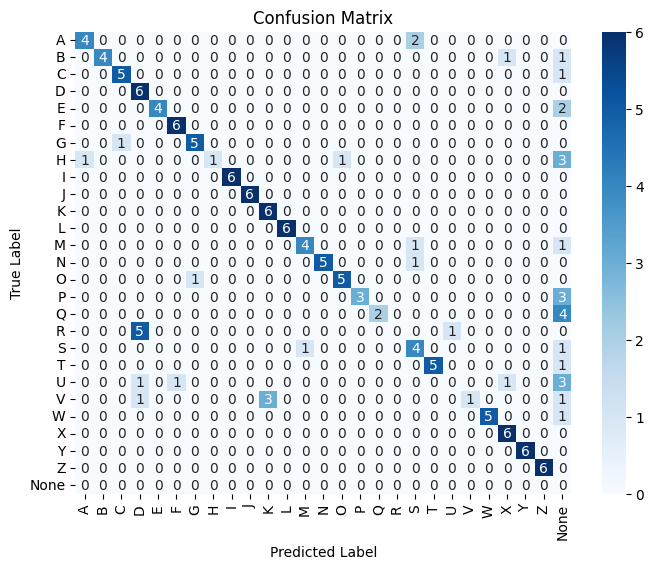

In [23]:
evaluate_model(OUTPUT_CSV)

# RESNET 152

In [24]:
selected_model = "faster_rcnn_resnet152"
MODEL = MODELS_CONFIG[selected_model]['model_name']
MODEL_FILE = MODEL + '.tar.gz'
PIPELINE_FILE = MODELS_CONFIG[selected_model]['pipeline_file']

DEST_DIR = '/content/pretrained_model/' + selected_model 
FINE_TUNE_CHECKPOINT = DEST_DIR + "/checkpoint/ckpt-0"
MODEL_DIR = TRAINING_DIR + '/' + selected_model
OUTPUT_DIRECTORY = '/content/fine_tuned_model/' + selected_model

OUTPUT_PATH = '/content/outputs/'
SAVED_DETECTION = OUTPUT_PATH + selected_model
SAVED_MODEL = OUTPUT_DIRECTORY + '/saved_model'
OUTPUT_CSV = f'{OUTPUT_PATH}output_{selected_model}.csv'

## Download Base Model Faster RCNN Inception V2 Resnet 152

In [82]:
DEST_DIR

'/content/pretrained_model/faster_rcnn_resnet152'

In [83]:
MODEL_FILE

'faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz'

In [84]:
%cd /content/pretrained_model
download_base_model(DEST_DIR, DOWNLOAD_BASE, MODEL_FILE, MODEL)

D:\content\pretrained_model
Folder /content/pretrained_model/faster_rcnn_resnet152 sudah ada. Tidak perlu mengunduh ulang base model.


In [85]:
!echo {DEST_DIR}
!dir "{DEST_DIR}"

/content/pretrained_model/faster_rcnn_resnet152
 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\pretrained_model\faster_rcnn_resnet152

11/07/2020  07:14    <DIR>          .
15/03/2024  16:57    <DIR>          ..
10/07/2020  11:08    <DIR>          checkpoint
11/07/2020  07:14             3.539 pipeline.config
10/07/2020  10:57    <DIR>          saved_model
               1 File(s)          3.539 bytes
               4 Dir(s)  28.474.732.544 bytes free


In [86]:
FINE_TUNE_CHECKPOINT

'/content/pretrained_model/faster_rcnn_resnet152/checkpoint/ckpt-0'

## Configuring a Training Pipeline

In [87]:
PIPELINE_FNAME = '/content/models/research/object_detection/configs/tf2/' + PIPELINE_FILE
assert os.path.isfile(PIPELINE_FNAME), '`{}` not exist'.format(PIPELINE_FNAME)

In [88]:
PIPELINE_FNAME = CONFIG_PATH + '/' + PIPELINE_FILE

In [60]:
!copy "D:\content\models\research\object_detection\configs\tf2\{PIPELINE_FILE}" "D:\content\configs"
PIPELINE_FNAME

        1 file(s) copied.


'/content/configs/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config'

In [61]:
modify_pipeline_config(PIPELINE_FNAME)

In [89]:
PIPELINE_FNAME

'/content/configs/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config'

In [90]:
!cat "D:\content\configs\faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config"

# Faster R-CNN with Resnet-152 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint
#
# Train on TPU-8
#
# Achieves 32.4 mAP on COCO17 val

model {
  faster_rcnn {
    num_classes: 26
    image_resizer {
      fixed_shape_resizer {
        width: 320
        height: 320
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet152_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_

In [91]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Directory '{MODEL_DIR}' created successfully.")

Directory '/content/training/faster_rcnn_resnet152' created successfully.


In [92]:
# Optionally remove content in output model directory to fresh start.
!rmdir /s /q "{MODEL_DIR}"
os.makedirs(MODEL_DIR, exist_ok=True)

In [95]:
!python "D:\content\models\research\object_detection\model_main_tf2.py" \
    --pipeline_config_path={PIPELINE_FNAME} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr \
    --num_train_steps={NUM_STEPS_TRAIN} \
    --num_eval_steps={NUM_STEPS_EVAL}

2024-04-25 23:50:49.489859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 23:50:50.016681: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0425 23:50:50.087683  4976 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 46800
I0425 23:50:50.090665  4976 config_util.py:552] Maybe overwriting train_steps: 46800
INFO:

In [93]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--alsologtostderr "
    "--model_dir={} "
    "--num_train_steps={} "
    "--num_eval_steps={} "
).format(PIPELINE_FNAME, MODEL_DIR, NUM_STEPS_TRAIN, NUM_STEPS_EVAL)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config --alsologtostderr --model_dir=/content/training/faster_rcnn_resnet152 --num_train_steps=46800 --num_eval_steps=52 


In [94]:
command = (
    "python /content/models/research/object_detection/model_main_tf2.py "
    "--pipeline_config_path={} "
    "--checkpoint_dir={} "
    "--model_dir={} "
).format(PIPELINE_FNAME, MODEL_DIR, MODEL_DIR)

print(command)

python /content/models/research/object_detection/model_main_tf2.py --pipeline_config_path=/content/configs/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.config --checkpoint_dir=/content/training/faster_rcnn_resnet152 --model_dir=/content/training/faster_rcnn_resnet152 


## Exporting a Trained Inference Graph

In [18]:
lst = os.listdir(MODEL_DIR)
lst = [l for l in lst if 'ckpt-' in l and '.index' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(MODEL_DIR, last_model)
print(last_model_path)

/content/training/faster_rcnn_resnet152\ckpt-47.index


In [19]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet152'

In [23]:
!python "D:\content\models\research\object_detection\exporter_main_v2.py" \
    --input_type image_tensor \
    --pipeline_config_path "D:\content\configs\{PIPELINE_FILE}" \
    --trained_checkpoint_dir {MODEL_DIR} \
    --output_directory {OUTPUT_DIRECTORY}

2024-03-13 14:00:22.579351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 14:00:23.513577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0313 14:00:23.734066 25136 deprecation.py:628] From C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\tensorflow\python\autograph\impl\api.py:45

In [24]:
!dir "{OUTPUT_DIRECTORY}"

 Volume in drive D is New Volume
 Volume Serial Number is 9615-09AD

 Directory of D:\content\fine_tuned_model\faster_rcnn_resnet152

13/03/2024  14:01    <DIR>          .
13/03/2024  14:00    <DIR>          ..
13/03/2024  14:00    <DIR>          checkpoint
13/03/2024  14:01             3.554 pipeline.config
13/03/2024  14:01    <DIR>          saved_model
               1 File(s)          3.554 bytes
               4 Dir(s)  33.743.081.472 bytes free


## Run Test model

In [25]:
%cd /content

D:\content


In [26]:
OUTPUT_DIRECTORY

'/content/fine_tuned_model/faster_rcnn_resnet152'

In [27]:
SAVED_DETECTION = '/content/outputs/' + selected_model
SAVED_MODEL = OUTPUT_DIRECTORY + '/saved_model'

In [28]:
!python ./detect_image_from_csv.py -m {SAVED_MODEL} -l {LABEL_MAP_PBTXT_FNAME} -i {CSV_TEST} -o {OUTPUT_CSV} -s {SAVED_DETECTION} 

2025-05-14 10:51:40.324609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 10:51:40.884745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-05-14 10:52:27.455613: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-05-14 10:52:33.681266: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesty\anaconda3\envs\tf210\lib\sit

Accuracy: 0.8076923076923077
Precision: 0.880846717385179
Recall: 0.8076923076923077
Average Execution Time: 453.56 ms
Total Execution Time: 70.76 s

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.83      0.91         6
           B       1.00      1.00      1.00         6
           C       1.00      1.00      1.00         6
           D       0.46      1.00      0.63         6
           E       1.00      1.00      1.00         6
           F       1.00      1.00      1.00         6
           G       1.00      1.00      1.00         6
           H       1.00      1.00      1.00         6
           I       1.00      0.83      0.91         6
           J       1.00      1.00      1.00         6
           K       0.75      1.00      0.86         6
           L       1.00      1.00      1.00         6
           M       0.00      0.00      0.00         6
           N       0.50      1.00      0.67         6
           O    

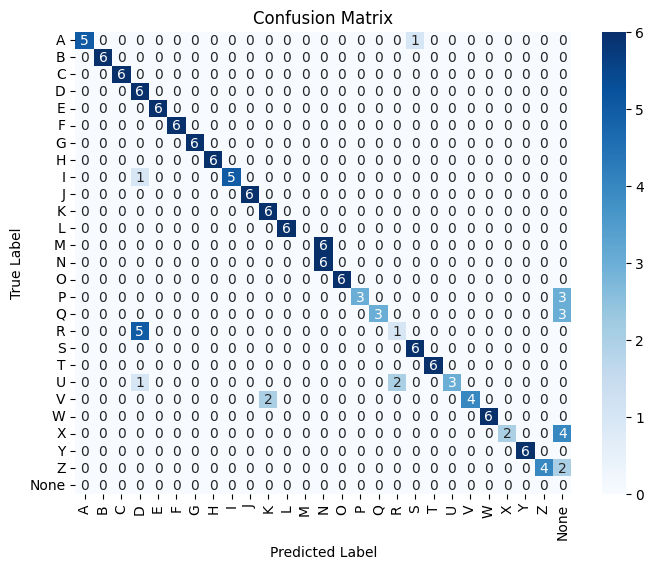

In [29]:
evaluate_model(OUTPUT_CSV)